# Neste exercício vamos aprender como utilizar uma Rede Neural CNN para classificar imagens de dígitos

In [25]:
# Importações
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# Novamente vamos utilizar o Dataset MNIST
# Importando o dataset MNIST (http://yann.lecun.com/exdb/mnist/)
from tensorflow.examples.tutorials.mnist import input_data
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Valores fixos relacionados à massa de treinamento
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

Vamos criar agora os mesmos parâmetros, adicionando o dropout

**dropout** - Utilizado para definir a remoção de alguns neurônios da rede ao final do treinamento, para evitar o overfitting

In [18]:
# Parâmetros do treinamento
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10
dropout = 0.75 # Dropout, probabilidade para manter unidades

In [6]:
# Vamos definir os tensores, um para os dados de entrada, outro para o de saída e outro para o dropout
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32) 

A diferença entre uma CNN e uma rede MLP é que o CNN preserva a proximidade dos pixels da imagens.

Ou seja, ao invém de trabalhar com a imagems como uma sequência de pixels de uma dimensão, utilizada 2 dimensões, visto que imagens são representadas em 2D

Para isso precisamos converter a entrada em matrizes 2D

In [7]:
# Convertendo o input (x) para um tensor
_X = tf.reshape(x, shape = [-1, 28, 28, 1])

Agora vamos definir funções para criar o modelo de rede neural

In [8]:
# A função tf.nn.conv2d() computa convoluções 2D a partir do tensor de input. A esse resultado adicionamos o bias.
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides = [1, 1, 1, 1], padding = 'VALID'), b))
# Após a operação de convolução, realizamos o passo de pooling que simplifica a informação de output previamente criada pela camada de convolução.
def max_pool(img, k):
    return tf.nn.max_pool(img, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'VALID')

O próximo passo é definir as variáveis que serão encontradas no treinamento, ou seja, os **pesos** e o **bias** de cada camada

In [9]:
# Cada neurônio da camada oculta é conectado a um pequeno grupo de tensores de entrada (input) de dimensão 5x5. 
wc1 = tf.Variable(tf.random_normal([5, 5, 1, 32])) # 5x5 conv, 1 input, 32 outputs
wc2 = tf.Variable(tf.random_normal([5, 5, 32, 64])) # 5x5 conv, 32 inputs, 64 outputs
wd1 = tf.Variable(tf.random_normal([4*4*64, 1024])) # fully connected, 7*7*64 inputs, 1024 outputs
wout = tf.Variable(tf.random_normal([1024, n_classes])) # 1024 inputs, 10 outputs (class prediction)
# Bias
bc1 = tf.Variable(tf.random_normal([32]))
bc2 = tf.Variable(tf.random_normal([64]))
bd1 = tf.Variable(tf.random_normal([1024]))
bout = tf.Variable(tf.random_normal([n_classes]))

Vamos agora utilizar as funções para criar nossa rede CNN

In [10]:
# Camada 1 de convolução
conv1 = conv2d(_X, wc1, bc1)

# Max Pooling (down-sampling)
conv1 = max_pool(conv1, k=2)

# Aplicando o Dropout
conv1 = tf.nn.dropout(conv1, keep_prob)

# Camada 2 de convolução
conv2 = conv2d(conv1,wc2,bc2)

# Max Pooling (down-sampling)
conv2 = max_pool(conv2, k=2)

# Aplicando o Dropout
conv2 = tf.nn.dropout(conv2, keep_prob)

# Camada totalmente conectada
dense1 = tf.reshape(conv2, [-1, wd1.get_shape().as_list()[0]]) # Reshape conv2 output to fit dense layer input
dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, wd1),bd1)) # Ativação com a Relu 
dense1 = tf.nn.dropout(dense1, keep_prob) # Aplicando Dropout

# Output, class prediction
pred = tf.add(tf.matmul(dense1, wout), bout)

Pronto, o modelo da nossa rede está criado

Resta agora definir a **função de custo** e a **função de otimização**

In [15]:
# Cost Function e Otimização
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))
tf.summary.scalar('cost', cost)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

Adicionamente, vamos definir uma função para o cálculo da acurácia, para ser utilizada a cada passo

In [21]:
# Avaliando o Modelo
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

Vamos executar agora o modelo no TF

Epoca 1280, Custo = 26464.140625, Acurácia = 0.05469
Epoca 2560, Custo = 20657.085938, Acurácia = 0.25781
Epoca 3840, Custo = 11398.941406, Acurácia = 0.30469
Treinamento Concluído com  4000  épocas!


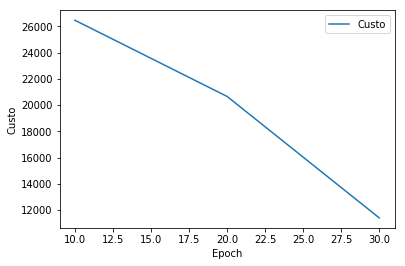

Acurácia final: 0.28125


In [26]:
# Criando variáveis para plotar o gráfico ao final
avg_cost_set = []
epoch_set = []
# Inicializando as variáveis
init = tf.global_variables_initializer()
# Sessão
with tf.Session() as sess:
    sess.run(init)
    merged = tf.summary.merge_all()
    now = datetime.now()
    writer = tf.summary.FileWriter('logs_09/'+now.strftime("%Y%m%d-%H%M%S"), sess.graph)
    step = 1
    # Mantém o treinamento até atingir o número máximo de iterações
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training , _ = usando batch data
        train_summary, _ = sess.run([merged, optimizer], feed_dict = {x: batch_xs, y: batch_ys, keep_prob: dropout})
        writer.add_summary(train_summary, step)
        if step % display_step == 0:
            # Calculando a acurácia
            acc = sess.run(accuracy, feed_dict = {x: batch_xs, y: batch_ys, keep_prob: 1.})
            # Calculando a perda
            loss = sess.run(cost, feed_dict = {x: batch_xs, y: batch_ys, keep_prob: 1.})
            print ("Epoca " + str(step*batch_size) + ", Custo = " + "{:.6f}".format(loss) + ", Acurácia = " + "{:.5f}".format(acc))
            avg_cost_set.append(loss)
            epoch_set.append(step)
        step += 1
    print ("Treinamento Concluído com ",training_iters," épocas!")
    writer.close()

    # Vamos plotar ao final o gráfico de custo por época de treinamento
    plt.plot(epoch_set,avg_cost_set, '-', label = 'Custo')
    plt.ylabel('Custo')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Calculando acurácia para 256 mnist test images
    print ("Acurácia final:", sess.run(accuracy, feed_dict = {x: mnist.test.images[:256], y: mnist.test.labels[:256], keep_prob: 1.}))


Abra o **TensorBoard** utilizando o comando abaixo e veja os gráficos de custo e acurácia gerados:
    
python -m tensorboard.main --logdir="logs_09"

# Exercício:

Modifique os parâmetros de treinamento e da rede e rode novamente a rede para ver se consegue melhorar o resultado

Registre em uma planilha Excel os valores utilizados para cada treinamento e os valores de **custo** e **acurácia** final obtidos

## Responda:

- Qual a influência do learning_rate?
- Qual a influência do batch_size?
- Qual a influência da quantidade de épocas?
- Qual a influência do parâmetro dropout?